# Monte-Carlo methods for Hard Sphere packings

Preamble: Run the cells below to import the necessary Python packages

*This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.*

In [37]:
import numpy as np
# from IPython.display import Image, display

import sys
# sys.path.append('../') # Add the course directory to the Python path
# import cphy.plotting as cplot

import matplotlib.pyplot as plt
%matplotlib inline


## Set nicer colors
plt.rcParams['image.cmap'] = 'PuBu'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[[1.0, .3882, .2784]])
plt.rcParams['lines.markersize'] = 10

## Comment out these lines if they throw an error on your system
## Set animation parameters
## Tune the ffmpeg writer (you need ffmpeg installed)
plt.rcParams["animation.writer"] = "ffmpeg"
plt.rcParams["animation.bitrate"] = 800                     # kb/s cap
plt.rcParams["animation.ffmpeg_args"] = [                   # finer control
    "-crf", "24",        # 18–28 is common; larger = smaller file
    "-preset", "slow",   # slower = better compression
    "-pix_fmt", "yuv420p"
]
plt.rcParams["animation.embed_limit"] = 25

## Gradient-free optimization

We saw before that many optimization methods implicitly require the locally-computed gradient of the potential $\nabla_\theta \mathcal{L}(\theta)$, either computed explicitly or using a heuristic like finite-difference approximation or automatic differentiation.

For problems for which the gradient is impossible to compute (i.e. discrete systems like cellular automata), we can genetic algorithms to optimize systems. But what about problems where it is possible to physically perform small perturbations, in the sense of applying changes that lead to bounded changes in the potential. We can't necessarily fully differentiate such systems, because the energy function itself is discontinuous in the perturbation. An example of this case is the Ising model Hamiltonian,
$$
    \mathcal{H}(\boldsymbol{s}) = -J\sum_i^{N-1} \sigma_i \sigma_{i+1}
$$
where $\sigma_i \in \{-1, 1\}$. When the number of spins is large ($N \to \infty$), the change in energy due to flipping a single spin $\sigma_i \to -\sigma_i$, is bounded. However, because the optimization variables are discrete, we cannot directly take the gradient of this function.

In other cases, the gradient exists and we could try directly approximating it using finite differences. However, this fails in high dimensions because approximating a $D$-dimensional gradient by finite differences costs $O(D)$ evaluations of the potential, where $D$ is the dimensionality of the system. If the potential is expensive to evaluate, this can be prohibitive. 

Monte Carlo methods can be used to optimize a potential without computing its gradient. This can be useful either when the gradient does not exist, or it is very expensive to compute. Like gradient methods, they exploit small perturbations to find local information about the potential to guide the search.

<br><br><br><br><br><br>


## The Metropolis algorithm

Given a system I want to optimize, suppose that I have a scalar energy function $E(\boldsymbol{\theta}) \in \mathbb{R}$ that depends on a vector of variables $\boldsymbol{\theta}$ that describe the system's configuration.

+ We initialize a system in a given configuration, $E(\boldsymbol{\theta})$

+ We apply a perturbation to the system's parameters, resulting in a new configuration $\boldsymbol{\theta}'$. Ideally, we have a method of perturbing the system such that the resulting change in the energy is bounded, even if it's not continuous.

+ We compute the change in energy between the proposed (perturbed) and original configuration, $\Delta E = E(\boldsymbol{\theta}) - E(\boldsymbol{\theta}')$

+ + If $\Delta E < 0$, we immediately accept the update, $\theta \to \theta'$

+ + If $\Delta E > 0$, we accept the new configuration with probability $\exp(-\beta \Delta E)$, where $\beta = 1/k_B T$ is the inverse temperature of the sampling process. 

### Properties of the Metropolis algorithm.

The inverse temperature $\beta$ as a critical hyperparameter that controls properties of the optimization. When $\beta \to \infty$, then we never accept higher energy steps. This corresponds to greedy dynamics, in which the system can only descend in energy. This is the abstract equivalent of the overdamped dynamics we saw in gradient descent. Conversely, when $\beta \to 0$, then we always accept the update, and so the optimization decouples from the energy of the state.

In both extremes, the decision whether to accept a step becomes fully deterministic. In practice, Monte Carlo methods work best when they are maximally stochastic, and so, in practice, $\beta$ is usually chosen so that we accept roughly half of all proposed updates.

Why not always set $\beta$ large?. We might think that the fastest convergence would occur if we always accepted updates that lower the energy, and always rejected updates that increase the energy (equivalent to $\beta=0$). The probabilistic update rule here represents a way for the optimizer to avoid getting stuck in local minima.


### Implementing the Metropolis optimizer

To implement the random choice, We will draw a random number, $\rho$, from a uniform distribution between 0 and 1. If $\rho < \exp(-\beta \Delta E)$, we accept a higher-energy configuration. Otherwise, we reject the new configuration and keep the old one. We will vectorize our implementation, in order to allow us to optimize particles starting at multiple initial positions simultaneously.

In [47]:

class MetropolisMonteCarlo:
    """
    Metropolis algorithm for optimizing a loss function.

    Attributes:
        energy (function): The loss function to be minimized
        beta (float): The inverse temperature
        amplitude (float): The amplitude of the perturbation applied to the state
        max_iter (int): The maximum number of iterations
        random_state (int): The random seed
        store_history (bool): Whether to store the history of the state
    """
    def __init__(
            self, 
            loss, 
            beta=1.0, 
            amplitude=1.0, 
            max_iter=500,
            random_state=None, 
            store_history=False
        ):
        self.energy = loss
        self.beta = beta
        self.amplitude = amplitude
        self.n_iter = max_iter
        self.store_history = store_history
        self.random_state = random_state

        self.store_history = store_history
        if self.store_history:
            self.Xs = []
            self.losses = []

    def perturb(self, X):
        """
        Randomly the state of the system.
        
        Args:
            X (ndarray): The current state of the system

        Returns:
            Xp (ndarray): The perturbed state of the system
        """
        Xp = X + self.amplitude * np.random.normal(size=X.shape)
        return Xp

    def update(self, X):
        """
        Update the state of the system.
        
        Args:
            X (ndarray): The current state of the system

        Returns
            X (ndarray): The updated state of the system
        """
        rho = np.random.random(X.shape[0])
        Xp = self.perturb(X)
        e_delta = self.energy(Xp) - self.energy(X)

        # Create vector of update or not

        do_update = np.zeros(X.shape[0])
        do_update[e_delta < 0] = 1
        do_update[rho < np.exp(-self.beta * e_delta)] = 1

        X_out = X.copy()
        X_out[do_update == 1] = Xp[do_update == 1]
        return X_out

    def fit(self, X):
        """
        Run the Monte Carlo simulation.
        
        Args:
            X (ndarray): The initial state of the system

        Returns:
            X (ndarray): The final state of the system
        """
        np.random.seed(self.random_state)
        if self.store_history:
            self.Xs.append(X)
            self.losses.append(self.energy(X))
        for _ in range(self.n_iter):
            X = self.update(X)
            if self.store_history:
                self.Xs.append(X)
                self.losses.append(self.energy(X))
        return X

(10000, 2)


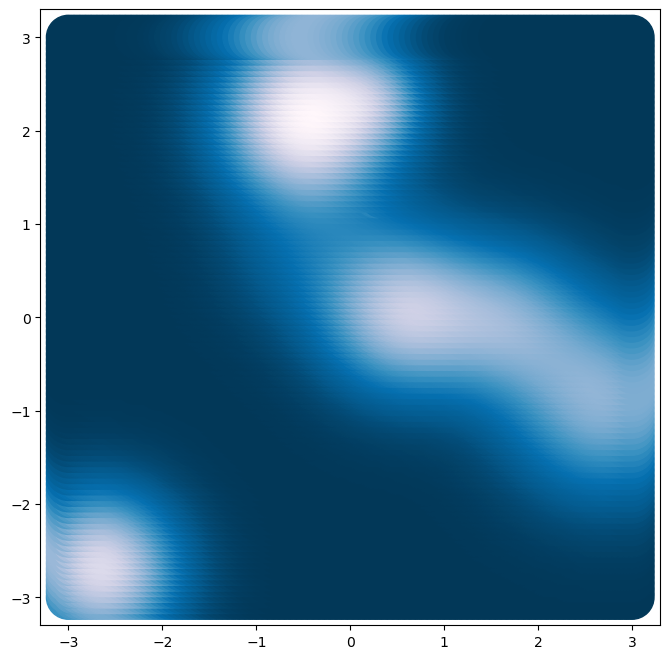

In [48]:

class RandomLossLandscape:
    """
    Creates a random two-dimensional loss landscape with multiple circular gaussian wells

    Args:
        d (int): number of dimensions for the loss landscape
        n_wells (int): number of gaussian wells
        random_state (int): random seed
    
    """

    def __init__(self, d=2, n_wells=3, random_state=None):
        
        # Fix the random seed
        self.random_state = random_state
        np.random.seed(random_state)

        # Select random well locations, widths, and amplitudes
        self.locs = (2 * np.random.uniform(size=(n_wells, d)) - 1) * 3
        self.widths = np.random.rand(n_wells)[None, :]
        self.coeffs = np.random.random(n_wells)
        self.coeffs /= np.sum(self.coeffs) # normalize the amplitudes

    def _gaussian_well(self, X, width=1):
        """
        A single gaussian well centered at 0 with specified width

        Args:
            X (np.ndarray): points at which to compute the gaussian well. This should 
                be of shape (n_batch, n_dim)
            width (float): The width of the gaussian well

        Returns:
            np.ndarray: The value of the gaussian well at points X. The shape of the output
                is (n_batch,)
        """
        return -np.exp(-np.sum((X / width) ** 2, axis=1))

    def _grad_gaussian_well(self, X, width=1):
        return -2 * X / (width ** 2) * self._gaussian_well(X, width)[:, None, :]

    def grad(self, X):
        # Arg shape before summation is (n_batch, n_dim, n_wells)
        return np.sum(
            self.coeffs * self._grad_gaussian_well(X[..., None] - self.locs.T[None, :], self.widths), 
            axis=-1
        )
    
    def loss(self, X):
        """
        Compute the loss landscape at points X

        Args:
            X (np.ndarray): points at which to compute the loss landscape. This should 
                be of shape (n_batch, n_dim)
            width (float): The width of the gaussian wells

        Returns:
            np.ndarray: loss landscape at points X

        Notes:
            The loss landscape is computed as the sum of the individual gaussian wells
            The shape of the argument to np.sum is (n_batch, n_wells)
        """
        return np.sum(
            self._gaussian_well(X[..., None] - self.locs.T[None, :], self.widths) * self.coeffs,
            axis=1
        )

    def __call__(self, X):
        return self.loss(X)

        
# Instantiate a random loss
loss = RandomLossLandscape(random_state=0, n_wells=8)
# loss.plot()
# plt.axis('off')

plt.figure(figsize=(8, 8))

## First we plot the scalar field at high resolution
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
print(X.shape)
Z = loss(X) # same as loss.loss(X) because class is callable
plt.scatter(X[:, 0], X[:, 1], c=Z, s=1000)


In [55]:

# Initialize optimizer
# optimizer = MetropolisMonteCarlo(loss, beta=1e2, amplitude=0.1, random_state=0, store_history=True)
optimizer = MetropolisMonteCarlo(loss, beta=1e8, amplitude=0.1, random_state=0, store_history=True)
# optimizer = MetropolisMonteCarlo(loss, beta=1e-2, amplitude=0.1, random_state=0, store_history=True)

# Initialize starting point
np.random.seed(0)
X0 = np.random.normal(loc=(0, 0.5), size=(100, 2))

# Fit optimizer
Xopt = optimizer.fit(X0.copy()).squeeze()

/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_75496/1626266535.py:65: RuntimeWarning: overflow encountered in exp
  do_update[rho < np.exp(-self.beta * e_delta)] = 1


Text(0, 0.5, 'Loss')

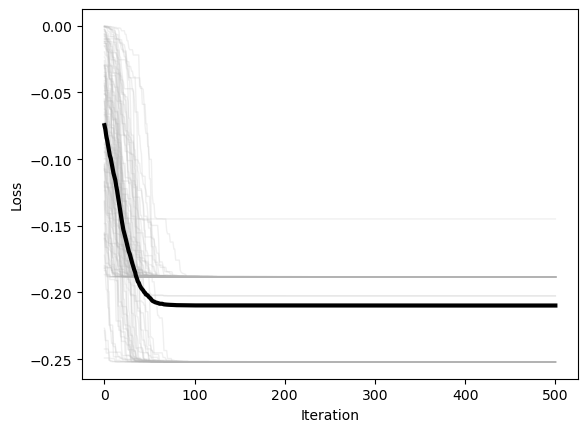

In [56]:
plt.figure()
plt.plot(optimizer.losses, color=(0.7, 0.7, 0.7), lw=1, alpha=0.2)
plt.plot(np.mean(optimizer.losses, axis=1), 'k', lw=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')


Text(0.5, 1.0, 'Trajectories')

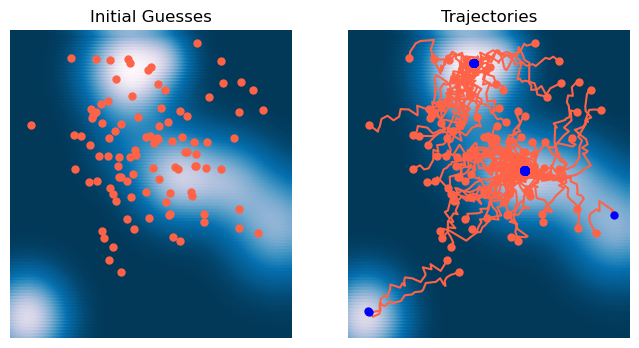

In [57]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x, y)
X = np.array([xx.ravel(), yy.ravel()]).T
Z = loss.loss(X)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(*X0.T, '.')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Initial Guesses')

plt.subplot(1, 2, 2)
Xs = np.array(optimizer.Xs)
plt.scatter(X[:, 0], X[:, 1], c=Z)
plt.plot(Xs[0, :, 0], Xs[0, :, 1], '.');
plt.plot(Xs[:, :, 0], Xs[:, :, 1], '-');
plt.plot(Xs[-1, :, 0], Xs[-1, :, 1], '.b', zorder=10);
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')
plt.title('Trajectories')

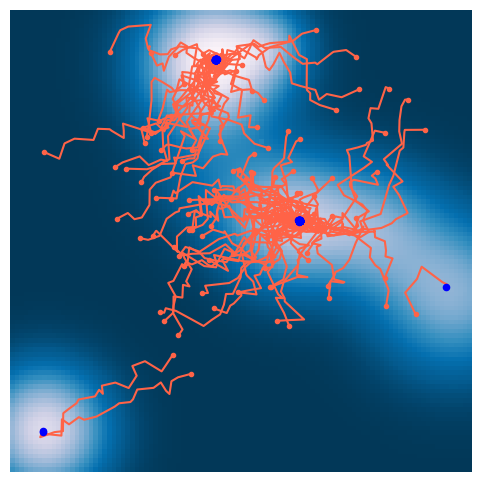

In [58]:
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from IPython.display import HTML

Xs = np.array(optimizer.Xs)[::2][:500]

fig, ax = plt.subplots(figsize=(6, 6))
# ax.scatter(X[:, 0], X[:, 1], c=Z, s=14, zorder=0)
plt.imshow(Z.reshape(100, 100), extent=[-3, 3, -3, 3], origin='lower')
ax.plot(Xs[0, :, 0], Xs[0, :, 1], '.', ms=6, linestyle='None', zorder=1)
curr = ax.scatter([], [], s=20, c='b', zorder=3)
trail = LineCollection([], zorder=2)
ax.add_collection(trail)

ax.set_xlim(-3, 3); ax.set_ylim(-3, 3); ax.axis('off')
plt.margins(0, 0); plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

def init():
    curr.set_offsets(np.array([0, 0]))
    trail.set_segments([])
    return (curr, trail)

def update(t):
    # current points
    curr.set_offsets(Xs[t])

    if t > 0:
        segs = []
        # Build one polyline per particle (skip if fewer than 2 points)
        for n in range(Xs.shape[1]):
            path = Xs[:t+1, n, :]  # (k,2)
            if path.shape[0] >= 2:
                segs.append(path)
        trail.set_segments(segs)


    return (curr, trail)

ani = FuncAnimation(fig, update, frames=min(500, Xs.shape[0]),
                    init_func=init, interval=100, blit=True, repeat=True)
html = ani.to_html5_video()                                 # replaces to_jshtml()
HTML(html)

## Hard sphere packing with the Metropolis algorithm

A basic problem in materials science, statistical physics, and the theory of disordered systems is to find the densest possible packing of hard spheres in a finite volume. Here, we will focus on the two-dimensional case of packing hard disks into a square domain. We define a "hard" sphere as a sphere of radius $R$ that cannot overlap with any other sphere. The packing fraction $\phi$ is the fraction of the total volume that is occupied by the spheres. In two dimensions, this is given by
$$
    \phi = \frac{N \pi R^2}{V}.
$$

The interaction potential between two spheres is given by
$$
V(r) = \begin{cases}
    \infty & r < 2R \\
    0 & r > 2R
\end{cases}
$$
where $r$ is the distance between the centers of the spheres. Note that, because we have an infinite potential, the Metropolis update step simplifies dramatically. Recall that, in traditional Metropolis, we calculate the ratio of the Boltzmann factors for the current and proposed configurations:

$$
    \frac{e^{-\beta E_{\text{new}}}}{e^{-\beta E_{\text{old}}}} = e^{-\beta (E_{\text{new}} - E_{\text{old}})}
$$

In our case, because the potential is either $0$ or $\infty$, the energy difference is either zero or infinity and so the ratio is either 1 or 0. This means that the acceptance probability is either 1 or 0, and we can simply accept or reject the proposed move based on whether the proposal causes an overlap between two spheres. The hyperparameter $\beta$ therefore vanishes from the Metropolis scheme for this system.


## Implementing hard sphere packing with the Metropolis algorithm

We will use a simulation box with periodic boundary conditions, so that the system is infinite in all directions. This means that we can place spheres anywhere in the simulation box, and we don't have to worry about the edges of the box. Rather than parametrizing the system in terms of the particle radius $R$, we will parameterize it in terms of specifying the packing fraction $\phi$, which equals the volume of the spheres divided by the volume of the simulation box. This is a more natural parameterization for the problem, because it is dimensionless.

At low $\phi$, we expect the spheres will be able to move around freely, and the system will be in a fluid state. At high $\phi$, the spheres will become jammed together, and the system will reach a solid state.

### References

+ [*Random Heterogeneous Materials: Microstructure and Macroscopic Properties*](https://doi.org/10.1007/978-1-4757-6355-3), by Sal Torquato




In [59]:
from scipy.spatial.distance import pdist
import itertools

## We define this helper function externally so we can use it outside of the class
def augment_lattice(coords):
    """
    Given a set of 2Dcoordinates, build an augmented lattice of coordinates by 
    shifting each coordinate by 1 in each direction.

    Args:
        coords (np.ndarray): coordinates of the particles of shape (N, 3)

    Returns:
        np.ndarray: augmented coordinates of shape (27 * N, 3)
    """
    coords_augmented = list()
    # there are 8 possible shifts to fully surround a simulation box with 
    # replicates to create boundary conditions.
    for shift in itertools.product([-1., 0., 1.], repeat=2):
        if np.sum(np.abs(shift)) == 0:
            continue # Skip the zero shift case, which is the identity
        coords_augmented.append(coords.copy() + np.array(shift))
    return np.vstack(coords_augmented).copy()


class HardDiskPacking:
    """
    Metropolis Monte Carlo for hard disks in 2D with periodic boundaries (unit square).

    Args:
        n (int): Number of particles.
        phi (float): Areal packing fraction (sum of disk areas / box area).
        zeta (float): Maximum trial displacement magnitude (in box-length units).
        store_history (bool): If True, stores coordinates after each sweep.

    Attributes:
        coords (np.ndarray): (N,2) array of particle centers in [0,1)×[0,1).
        diameter (float): Disk diameter implied by (n, phi) in a unit-area box.
        acceptance_rate (float): Fraction of accepted trial moves.
        history (list[np.ndarray] | None): Optional trajectory snapshots.
    """

    def __init__(self, n, phi, zeta=0.005, store_history=False):
        self.N = int(n)
        self.phi = float(phi)
        self.zeta = float(zeta)
        self.store_history = bool(store_history)

        # Square lattice initialization in the unit square
        self.coords = self._initialize_lattice()

        # For 2D: phi = N * (pi/4) * d^2  (box area = 1)  ⇒ d = sqrt(4*phi/(pi*N))
        self.diameter = np.sqrt(4.0 * self.phi / (np.pi * self.N))
        # Back-compat with original naming if downstream code expects "radius"
        self.radius = self.diameter

        self.acceptance_rate = None
        if self.store_history:
            self.history = [self.coords.copy()]

    def _initialize_lattice(self):
        """Square mesh in [0,1)^2 with the first N points taken."""
        nx = ny = int(np.ceil(self.N**0.5))
        x = np.linspace(0.0, 1.0, nx, endpoint=False)
        y = np.linspace(0.0, 1.0, ny, endpoint=False)
        xx, yy = np.meshgrid(x, y, indexing="ij")
        coords = np.column_stack((xx.ravel(), yy.ravel()))
        return coords[:self.N].copy()

    def _overlaps(self, coords, i):
        """
        Check if particle i overlaps any other using the minimum-image convention.

        Overlap criterion: |r_i - r_j| < diameter.
        """
        # Displacements to all particles
        disp = coords[i] - coords
        # Minimum-image in a unit box (maps to [-0.5,0.5))
        disp -= np.rint(disp)
        # Distances; exclude self (zero distance)
        dists = np.hypot(disp[:, 0], disp[:, 1])
        dists = dists[dists > 0.0]
        return np.any(dists < self.diameter)

    def fit(self, num_iter=1000, verbose=False):
        """
        Run num_iter Monte Carlo sweeps (each sweep: N single-particle trials).

        Args:
            num_iter (int): Number of sweeps.
            verbose (bool): Print progress every 50 sweeps.

        Returns:
            self
        """
        accepts, rejects = 0, 0

        for it in range(num_iter):
            for j in range(self.N):
                trial = self.coords.copy()
                # Random displacement in 2D within [-zeta, zeta]^2
                trial[j] = (trial[j] + self.zeta * (2.0 * np.random.rand(2) - 1.0)) % 1.0

                if not self._overlaps(trial, j):
                    self.coords[j] = trial[j]
                    accepts += 1
                else:
                    rejects += 1

            if verbose and (it % 50 == 0):
                print(f"sweep {it}")

            if self.store_history:
                self.history.append(self.coords.copy())

        self.acceptance_rate = accepts / (accepts + rejects) if (accepts + rejects) else 0.0
        return self




In [75]:
## Run simulation

hdp = HardDiskPacking(100, 0.7, zeta=0.02, store_history=True)

hdp.fit(num_iter=500, verbose=True)
## Save the history because this simulation is demanding
# np.savez('../private_resources/monte_carlo_metropolis.npz', np.array(hsp.history))

print(f"Terminated Metropolis with average acceptance rate {hdp.acceptance_rate}")

sweep 0
sweep 50
sweep 100
sweep 150
sweep 200
sweep 250
sweep 300
sweep 350
sweep 400
sweep 450
Terminated Metropolis with average acceptance rate 0.13516


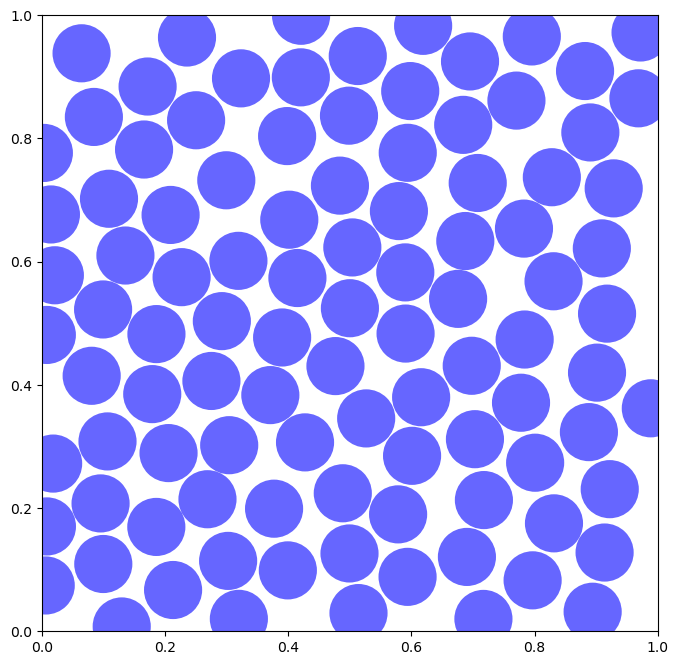

In [76]:
import numpy as np
from matplotlib.collections import EllipseCollection
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from IPython.display import HTML
import shutil

def make_video_from_history(hdp, interval=100, repeat=True, save_path=None, r=0.1):
    """
    Args:
        hdp: Object with attribute `history` that is an indexable sequence where each
            element is an (N, 2) array of point coordinates for that frame.
        interval (int): Delay between frames in milliseconds.
        repeat (bool): Whether the animation repeats when finished.
        save_path (str or None): If provided (e.g., 'out.mp4' or 'out.gif'), the animation
            will be written to this file.
        r (float): Circle radius in *data/axis* units.

    Returns:
        (matplotlib.animation.FuncAnimation): The animation object (also displayable via HTML()).
    """
    frames = len(hdp.history)
    if frames == 0:
        raise ValueError("hdp.history appears to be empty.")

    # Initial frame
    coords0 = np.asarray(hdp.history[0])
    if coords0.ndim != 2 or coords0.shape[1] != 2:
        raise ValueError("Each entry of hdp.history must be an (N, 2) array of coordinates.")

    fig, ax = plt.subplots(figsize=(8, 8))

    # --- EllipseCollection in *data units* (width/height are 2*r) ---
    w0 = np.full(len(coords0), 2*r)
    h0 = np.full(len(coords0), 2*r)
    ec = EllipseCollection(
        w0, h0, np.zeros(len(coords0)),
        units='xy',                      # widths/heights are in data units
        offsets=coords0, offset_transform=ax.transData,
        facecolor='b', edgecolor='none', alpha=0.6
    )
    ec.set_animated(True)               # better blitting
    ax.add_collection(ec)

    # Axes housekeeping
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')

    # Track current number of ellipses so we can adjust if N varies by frame
    state = {"n": len(coords0)}

    def _ensure_sizes(n):
        """Resize widths/heights arrays if N changes across frames."""
        if n != state["n"]:
            ec.set_widths(np.full(n, 2*r))
            ec.set_heights(np.full(n, 2*r))
            ec.set_angles(np.zeros(n))
            state["n"] = n

    def init():
        ec.set_offsets(coords0)
        _ensure_sizes(len(coords0))
        return (ec,)

    def update(t):
        pts = np.asarray(hdp.history[t])
        _ensure_sizes(len(pts))
        ec.set_offsets(pts)
        return (ec,)

    ani = FuncAnimation(
        fig, update, frames=frames, init_func=init,
        interval=interval, blit=True, repeat=repeat
    )

    # Optional save
    if save_path is not None:
        fps = max(1, int(1000 / interval))
        if save_path.lower().endswith(".gif"):
            ani.save(save_path, writer=PillowWriter(fps=fps))
        else:
            if shutil.which("ffmpeg") is not None:
                ani.save(save_path, writer=FFMpegWriter(fps=fps, bitrate=1800))
            else:
                fallback = save_path.rsplit(".", 1)[0] + ".gif"
                ani.save(fallback, writer=PillowWriter(fps=fps))
                print(f"ffmpeg not found. Saved GIF instead at: {fallback}")

    return ani

ani = make_video_from_history(hdp, interval=100, repeat=True, r=hdp.radius/2)
HTML(ani.to_html5_video())


We can see what happens in this system. At low packing fractions $\phi$ the particles move around freely, only occasionally colliding with one another. However, as the packing fraction grows, a lower fraction of moves get accepted because the particles are caged in, fewer possible motions. Even though we initialize the system in a square configuration, we can see that, at high packing fractions, it approaches hexagonal ordering, which is a slightly denser packing. In fact, hexagonal ordering is the densest possible packing at $\pi/\sqrt{12} \approx 0.91$.



### What happens as we vary the packing fraction?

In [34]:
phi_range = np.linspace(0.01, 0.9, 10)

final_coords = list()
for phi in phi_range:
    hdp = HardDiskPacking(400, phi, zeta=0.01, store_history=True)
    hdp.fit(num_iter=1000, verbose=False)
    print(f"At packing fraction {phi}, Metropolis had average acceptance rate {hdp.acceptance_rate}")

    coords = hdp.history[-1]
    final_coords.append(coords.copy())


At packing fraction 0.01, Metropolis had average acceptance rate 0.97111
At packing fraction 0.10888888888888888, Metropolis had average acceptance rate 0.8749425
At packing fraction 0.20777777777777778, Metropolis had average acceptance rate 0.8048475
At packing fraction 0.30666666666666664, Metropolis had average acceptance rate 0.7180275
At packing fraction 0.40555555555555556, Metropolis had average acceptance rate 0.6138825
At packing fraction 0.5044444444444445, Metropolis had average acceptance rate 0.4831475
At packing fraction 0.6033333333333333, Metropolis had average acceptance rate 0.3227825
At packing fraction 0.7022222222222222, Metropolis had average acceptance rate 0.1409175
At packing fraction 0.8011111111111111, Metropolis had average acceptance rate 0.0
At packing fraction 0.9, Metropolis had average acceptance rate 0.0


We can see the onset of this jammed state by looking at the acceptance ratio as a function of packing fraction. As the packing fraction approaches $0.91$, the fraction of accepted proposals drops to zero because there are no valid configurations.

<br><br><br><br><br><br>

## The pairwise correlation function

The pairwise correlation function is defined as the probability of finding a particle at a distance $r$ from another particle, given that the other particle is at the origin. It is given by

$$
g_2(r) = \frac{1}{\rho N} \langle \sum_{i=1}^N \sum_{j \neq i} \delta(r - |\mathbf{r}_i - \mathbf{r}_j|) \rangle
$$

where $\rho$ is the overall number density of particles. The sum over $j$ excludes the $i=j$ term, which would be infinite. The delta function ensures that the sum is only over pairs of particles that are separated by a distance $r$. The factor of $1/N$ ensures that the sum is normalized by the number of particles, while the factor of $1/\rho$ ensures that the sum is normalized by the volume of the system.

For finite-size systems, $g_2(r)$ as defined here appears "spiky," comprising a series corresponding to all possible pairs of particles. In the thermodynamic limit, however, the spikes become infinitely narrow and the function becomes smooth. In order to estimate $g_2(r)$ for a finite-size system, we must smooth the function by binning it. We will use a bin size of $\Delta r$. In this case, the correlation function is given by

$$
g_2(r) = \frac{1}{\rho N} \langle \sum_{i=1}^N \sum_{j \neq i} \frac{1}{\Delta r} \Theta(r - |\mathbf{r}_i - \mathbf{r}_j|) \rangle
$$

where $\Theta$ is the Heaviside step function. The factor of $1/\Delta r$ ensures that the sum is normalized by the bin size.


In [95]:
from scipy.spatial.distance import cdist

def compute_g2(coords, nbins=180, rmax=0.5):
    """
    Pair correlation g(r) in 2D. If the average density is not known in advance, 
    estimate it from the tail average.

    Args:
        coords (np.ndarray): Coordinates of the particles (N, 2).
        nbins (int): Number of histogram bins (edges returned; g2 has nbins-1).
        rmax (float): Max separation considered.

    Returns:
        bins (np.ndarray): Bin edges (length nbins).
        g2 (np.ndarray): Pair correlation values (length nbins-1).
    """
    D = cdist(coords, coords)  # pairwise distances
    bins = np.linspace(0, rmax, nbins)
    hist, bins = np.histogram(D, bins=bins)

    # 2D shell area: π (r_{k+1}^2 - r_k^2)
    shell_area = np.pi * (bins[1:]**2 - bins[:-1]**2)
    g2 = hist / (len(coords) * shell_area)

    # Optional: normalize by tail average
    g2 = g2 / g2[-3:].mean()
    g2[0] = 0 # Get rid of self term
    return bins, g2


sweep 0
sweep 50
sweep 100
sweep 150
sweep 200
sweep 250
sweep 300
sweep 350
sweep 400
sweep 450
sweep 500
sweep 550
sweep 600
sweep 650
sweep 700
sweep 750
sweep 800
sweep 850
sweep 900
sweep 950
sweep 1000
sweep 1050
sweep 1100
sweep 1150
sweep 1200
sweep 1250
sweep 1300
sweep 1350
sweep 1400
sweep 1450
sweep 1500
sweep 1550
sweep 1600
sweep 1650
sweep 1700
sweep 1750
sweep 1800
sweep 1850
sweep 1900
sweep 1950


Text(0, 0.5, '$g_2(r)$')

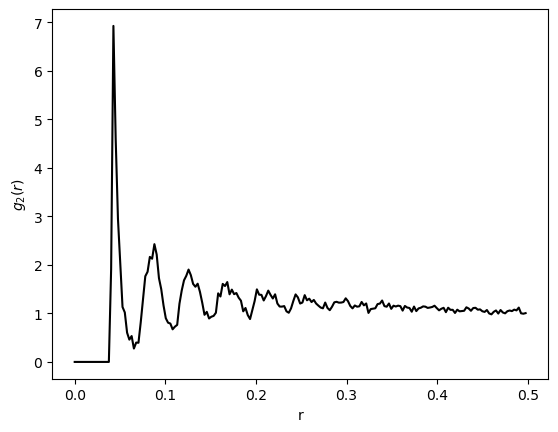

In [ ]:
# hdp = HardDiskPacking(200, 0.2, zeta=0.02, store_history=True)
# hdp = HardDiskPacking(200, 0.7, zeta=0.02, store_history=True)
# hdp = HardDiskPacking(500, 0.7, zeta=0.02, store_history=True)
hdp.fit(num_iter=2000, verbose=True)
packing_coords = hdp.history[-1]


bins, hist = compute_g2(augment_lattice(packing_coords), nbins=200)
plt.figure()
plt.plot(bins[:-1], hist, 'k')
plt.xlabel(r'r')
plt.ylabel(r'$g_2(r)$')

# plt.figure()
# fig = plt.figure()
# plt_sphere(hsp.history[1].copy(), hsp.radius)
# plt.xlim([-0.5, 0.5])
# plt.ylim([-0.5, 0.5])
# plt.gca().set_zlim([-0.5, 0.5])

# fig = plt.figure()
# plt_sphere(hsp.history[-1].copy(), hsp.radius),
# plt.xlim([-0.5, 0.5])
# plt.ylim([-0.5, 0.5])
# plt.gca().set_zlim([-0.5, 0.5]) 

We can compare our results to the typical appearance of the correlation function for a dense packing of hard spheres. The correlation function is a smooth function that decays to one (the asymptotic average density) at long distances.

<img src="../resources/percus_yevick.png" style="max-width:40%; height:auto;">

* The correlation function computed from molecular dynamics simulations, as well as an analytic approximate solution for g(r). Image from [Wang et al. PRE 2010](https://doi.org/10.1103/PhysRevE.81.061204)*



## Questions

+ We have a double loop: an outer loop over all iterations, and an inner loop where we go over each individual particle, jostle it, and check for overlaps. Why can't this inner loop be vectorized?

+ How would we generalize this approach to a soft-repulsive potential?

<img src="../resources/hardsphere_diagram.png" style="max-width:40%; height:auto;">

*Image from [Rintoul & Torquato. JCP 1996](https://doi.org/10.1063/1.473004)*


In [115]:
from scipy.spatial.distance import pdist
import itertools

class SoftDiskPacking(HardDiskPacking):
    """
    Metropolis Monte Carlo for hard disks in 2D with periodic boundaries (unit square).

    Args:
        n (int): Number of particles.
        phi (float): Areal packing fraction (sum of disk areas / box area).
        softness (float): The frequency of accepting overlaps
        zeta (float): Maximum trial displacement magnitude (in box-length units).
        store_history (bool): If True, stores coordinates after each sweep.

    Attributes:
        coords (np.ndarray): (N,2) array of particle centers in [0,1)×[0,1).
        diameter (float): Disk diameter implied by (n, phi) in a unit-area box.
        acceptance_rate (float): Fraction of accepted trial moves.
        history (list[np.ndarray] | None): Optional trajectory snapshots.
    """

    def __init__(self, n, phi, softness=1.0, **kwargs):
        super().__init__(n, phi, **kwargs)
        self.softness = softness

    def fit(self, num_iter=1000, verbose=False):
        """
        Run num_iter Monte Carlo sweeps (each sweep: N single-particle trials).

        Args:
            num_iter (int): Number of sweeps.
            verbose (bool): Print progress every 50 sweeps.

        Returns:
            self
        """
        accepts, rejects = 0, 0

        for it in range(num_iter):
            for j in range(self.N):
                trial = self.coords.copy()
                # Random displacement in 2D within [-zeta, zeta]^2
                trial[j] = (trial[j] + self.zeta * (2.0 * np.random.rand(2) - 1.0)) % 1.0

                accept_higher = np.random.uniform() < self.softness
                if not self._overlaps(trial, j) or accept_higher:
                    self.coords[j] = trial[j]
                    accepts += 1
                else:

                    rejects += 1

            if verbose and (it % 50 == 0):
                print(f"sweep {it}")

            if self.store_history:
                self.history.append(self.coords.copy())

        self.acceptance_rate = accepts / (accepts + rejects) if (accepts + rejects) else 0.0
        return self



In [127]:
hdp = SoftDiskPacking(100, 0.7, softness=0.01, zeta=0.02, store_history=True)

hdp.fit(num_iter=500, verbose=True)
## Save the history because this simulation is demanding
# np.savez('../private_resources/monte_carlo_metropolis.npz', np.array(hsp.history))

print(f"Terminated Metropolis with average acceptance rate {hdp.acceptance_rate}")

sweep 0
sweep 50
sweep 100
sweep 150
sweep 200
sweep 250
sweep 300
sweep 350
sweep 400
sweep 450
Terminated Metropolis with average acceptance rate 0.15534


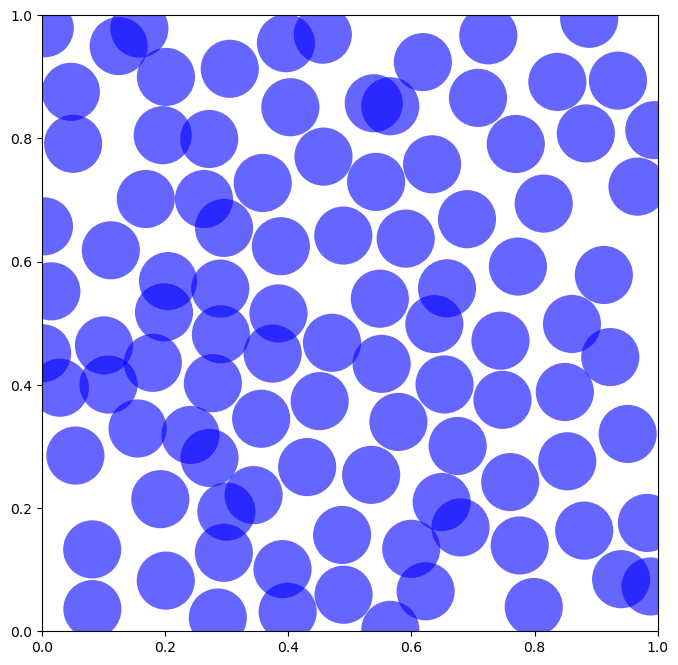

In [128]:
## Run simulation
ani = make_video_from_history(hdp, interval=100, repeat=True, r=hdp.radius/2)
HTML(ani.to_html5_video())

Text(0, 0.5, '$g_2(r)$')

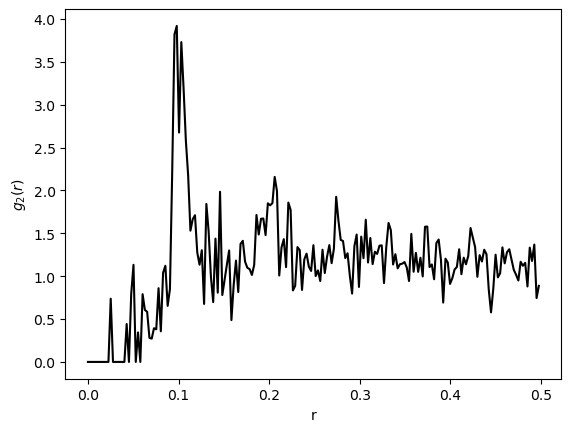

In [129]:
packing_coords = hdp.history[-1]
bins, hist = compute_g2(augment_lattice(packing_coords), nbins=200)
plt.figure()
plt.plot(bins[:-1], hist, 'k')
plt.xlabel(r'r')
plt.ylabel(r'$g_2(r)$')

### What about long-range interactions?

+ For the hard-sphere system, we needed to compute the energy change based on the potentially-overlapping neighbors of each particle.

+ Locality: When a single particle position updates, we only need to check locally for potential new overlaps---we don't have to check particles that are across the lattice.

+ For N particles with volume $v$ in a volume $V$, the number density is $\rho = N/v$. The number of overlapping neighbors is therefore, on average, equal to $K = N v / V$.

+ The energy update for the hard-sphere potential therefore takes $O(N K)$ time to compute. Usually, $K \ll N$ and so we say the cost is $O(N)$. This is also true for soft-spheres, and it is effectively true for short-range potentials like the Lennard-Jones potential.

+ But what about gravitationally-interacting systems? For every update, we have to check interactions with every other particle. This is $O(N^2)$, and it is a major computational bottleneck for gravitational N-body simulations.

+ One solution involves using approximate force fields for long-range interactions. Examples of algorithms that do this include the Barnes-Hut algorithm, the Fast Multipole Method, and Ewald summation.

## Further reading

A recent [modification of the Metropolis algorithm by Muller et al.](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.031006), rearranges the acceptance step

$$
\Delta E = -\dfrac{\log \rho}{\beta} \equiv \Delta E_{th}
$$

where $\rho$ is a random number between 0 and 1. This approach therefore re-frames the Metropolis update as determining whether the proposed energy change $\Delta E$ lies above or below the random threshold $\Delta E_{th}$.

The key insight of Müller et al. is that $\Delta E$ does not need to be known exactly. Rather, it is sufficient to gradually update a set of upper and lower bounds, $\Delta E \in [\Delta E_{min}, \Delta E_{max}]$. If $\Delta E_{min} < \Delta E_{th}$ then the update is accepted. If $\Delta E_{max} < \Delta E_{th}$ then the update is rejected probabilistically.

Thus, rather than exactly compute the energy change, the authors can use a tree-like decomposition of the domain to gradually improve bounds on the true energy change, until one of the stopping conditions above is triggered. Importantly, this is an *exact* algorithm, and it does not require any approximations.

From the Martiniani lab: [basins of attraction video for soft repulsive particles](https://www.youtube.com/watch?v=j7o6IuPYkwE)


<br><br><br><br><br><br>